# Store Sales - Time Series Forecasting

Store Sales - Time Series Forecasting" yarışması kapsamında mağaza satışlarını tahmin etmek amacıyla hazırlanmıştır. Zaman serisi analizine dayalı olarak, geçmiş satış verileri ve çeşitli yardımcı değişkenler (tatiller, petrol fiyatları, promosyonlar vb.) kullanılarak gelecekteki satış miktarları tahmin edilmiştir.

Bu çalışmada XGBoost regresyon modeli tercih edilmiştir. Modelin başarısı, zaman serisi doğrulama yöntemiyle (Time Series Cross Validation) Kök Ortalama Kare Hatası (RMSE) metriği üzerinden değerlendirilmiştir.

## 🔗 Hugging Face
Hugging Face üzerindeki [Sales Time Series Forecasting](https://huggingface.co/spaces/btulftma/sales-time-seriesforecasting) uygulamasını ziyaret edebilirsiniz.

## 🔗 Veri Kümesi
Veriler, Kaggle'daki [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview) yarışmasından alınmıştır. Proje, aşağıdaki veri dosyalarını kullanmaktadır:

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import holidays

In [7]:
# Verileri yükle
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv', parse_dates=['date'])
holidays_events = pd.read_csv('holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('transactions.csv', parse_dates=['date'])

In [8]:
# Verileri birleştir
train = pd.merge(train, stores, on='store_nbr', how='left')
test = pd.merge(test, stores, on='store_nbr', how='left')
train = pd.merge(train, oil, on='date', how='left')
test = pd.merge(test, oil, on='date', how='left')

In [9]:
# Tatil verilerini işle
ec_holidays = holidays.CountryHoliday('EC', years=range(2013, 2018))
train['is_holiday'] = train['date'].apply(lambda x: x in ec_holidays)
test['is_holiday'] = test['date'].apply(lambda x: x in ec_holidays)

In [10]:
for df in [train, test]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [7]:
le = LabelEncoder()
train['family'] = le.fit_transform(train['family'])
test['family'] = le.transform(test['family'])

In [8]:
# Petrol fiyatlarını lineer interpolasyon ile doldur
train['dcoilwtico'] = train['dcoilwtico'].interpolate(method='linear')
test['dcoilwtico'] = test['dcoilwtico'].interpolate(method='linear')

In [9]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

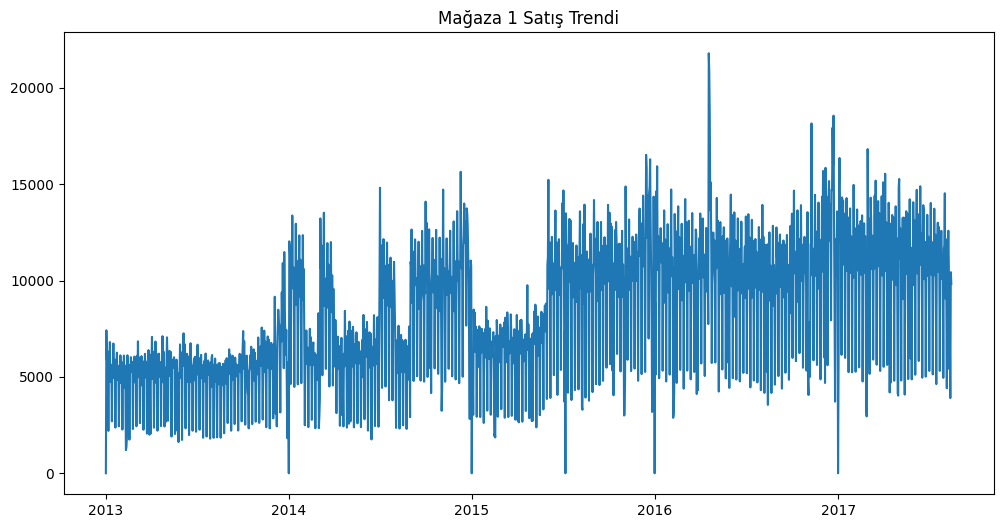

In [10]:
sample_store = train[train['store_nbr'] == 1].groupby('date')['sales'].sum()
plt.figure(figsize=(12, 6))
plt.plot(sample_store)
plt.title('Mağaza 1 Satış Trendi')
plt.show()

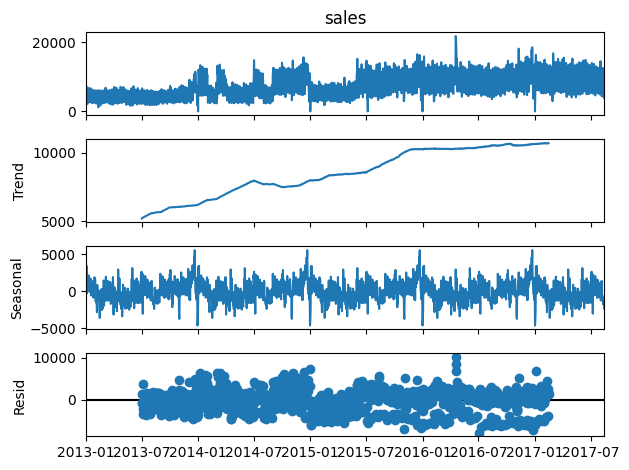

In [11]:
# Mevsimsellik ve trend
decomposition = seasonal_decompose(sample_store, model='additive', period=365)
decomposition.plot()
plt.show()

In [12]:
# Özellikler ve hedef değişken
features = ['store_nbr', 'family', 'onpromotion', 'dcoilwtico', 'year', 'month', 'day', 'day_of_week', 'is_weekend', 'is_holiday', 'cluster']
X = train[features]
y = train['sales']

In [13]:
# Zaman serisi cross-validation
tscv = TimeSeriesSplit(n_splits=3)
rmse_scores = []

for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    print(f"RMSE: {rmse:.2f}")

print(f"Ortalama RMSE: {np.mean(rmse_scores):.2f}")

RMSE: 486.54
RMSE: 603.47
RMSE: 483.15
Ortalama RMSE: 524.39


In [14]:
# Test verisi üzerinde tahmin
X_test = test[features]
test['sales'] = model.predict(X_test)

In [15]:
submission = test[['id', 'sales']]
submission.to_csv('submission.csv', index=False)

Modelin çapraz doğrulama sonuçlarına göre ortalama RMSE değeri 524.39 olarak hesaplanmıştır ve Kaggle yarışmasındaki ilk skor 1.78486 olarak elde edilmiştir. Daha iyi sonuçlar almak için ek özellik mühendisliği, hiperparametre optimizasyonu, farklı algoritmaların denenmesi ve veri setine hava durumu veya ekonomik göstergeler gibi ek değişkenler eklenmesi gibi yöntemler uygulanabilir.